<a href="https://colab.research.google.com/github/MineralizaTec/MineralizaTec/blob/main/Redenes_Neuronales.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# =======================
# 1. IMPORTACIÓN DE LIBRERÍAS
# =======================
import pandas as pd
import numpy as np

# =======================
# 2. CARGA DEL EXCEL
# =======================
# Reemplaza la ruta por la tuya si es diferente
file_path = "/content/ANN.xlsx"

# Leer la hoja correcta (en tu caso 'Hoja1')
df = pd.read_excel(file_path, sheet_name="Hoja1")

# =======================
# 3. CONVERSIÓN DE COLUMNAS SÍ/NO a 1/0
# =======================
columns_si_no = [
    "Techo abovedado",
    "Presencia de gradas en el techo",
    "Fallas/Fracturas desfavorables",
    "Presencia de agua"  # importante: así se llama en tu archivo
]

# Función de conversión
def si_no_to_binary(x):
    return 1 if str(x).strip().upper() == "SÍ" else 0

# Aplicar conversión
for col in columns_si_no:
    df[col + "_bin"] = df[col].apply(si_no_to_binary)

# =======================
# 4. CALCULAR Total_calc
# =======================
df['Total_calc'] = df[[col + "_bin" for col in columns_si_no]].sum(axis=1)

# =======================
# 5. ASEGURAR VARIABLES NUMÉRICAS
# =======================
df["RMR"] = pd.to_numeric(df["RMR"], errors="coerce")
df["Q"] = pd.to_numeric(df["Q"], errors="coerce")
df["RQD%"] = pd.to_numeric(df["RQD%"], errors="coerce")

# =======================
# 6. NORMALIZAR RIESGOS
# =======================

# --- RQD ---
rqd_max = df["RQD%"].max()
rqd_min = df["RQD%"].min()
df["RQD_risk"] = 1 - (df["RQD%"] - rqd_min) / (rqd_max - rqd_min)

# --- RMR ---
rmr_max = df["RMR"].max()
rmr_min = df["RMR"].min()
df["RMR_risk"] = 1 - (df["RMR"] - rmr_min) / (rmr_max - rmr_min)

# --- Q' ---
q_max = df["Q"].max()
q_min = df["Q"].min()
df["Q_risk"] = 1 - (df["Q´"] - q_min) / (q_max - q_min)

# =======================
# 7. CALCULAR PROBABILIDAD DE CAÍDA DE ROCAS
# =======================

df["probabilidad de caida de rocas"] = (
    (df["Total_calc"] / 4) * 0.4 +  # peso 40%
    df["RMR_risk"] * 0.2 +          # peso 20%
    df["Q_risk"] * 0.2 +            # peso 20%
    df["RQD_risk"] * 0.2            # peso 20%
)

# Limitar a [0,1]
df["probabilidad de caida de rocas"] = df["probabilidad de caida de rocas"].clip(0,1)

# =======================
# 8. MOSTRAR PRIMERAS FILAS
# =======================
print(df[[
    "Total_calc", "RMR", "Q", "RQD%",
    "RMR_risk", "Q_risk", "RQD_risk", "probabilidad de caida de rocas"
]].head(10))

# =======================
# 9. OPCIONAL: GUARDAR NUEVO EXCEL
# =======================
# Guardar el dataframe con la nueva columna
df.to_excel("ANN_resultado_con_probabilidad_Verdadero1.xlsx", index=False)
print("Archivo guardado como 'ANN_resultado_con_probabilidad.xlsx'")

   Total_calc  RMR         Q       RQD%  RMR_risk    Q_risk  RQD_risk  \
0           3   46  1.972776  59.183271  0.538462  0.528469  0.400732   
1           2   48  1.656568  66.262727  0.487179  0.604218  0.269972   
2           1   49  2.330098  69.902928  0.461538  0.442871  0.202736   
3           2   45  2.452530  73.575888  0.564103  0.413541  0.134895   
4           3   43  2.089410  62.682312  0.615385  0.500528  0.336104   
5           1   53  2.452530  73.575888  0.358974  0.413541  0.134895   
6           2   46  2.452530  73.575888  0.538462  0.413541  0.134895   
7           2   48  2.208758  66.262727  0.487179  0.471938  0.269972   
8           2   43  1.567058  62.682312  0.615385  0.625661  0.336104   
9           2   43  2.208758  66.262727  0.615385  0.471938  0.269972   

   probabilidad de caida de rocas  
0                        0.593533  
1                        0.472274  
2                        0.321429  
3                        0.422508  
4               

In [2]:
# =======================
# 1. IMPORTAR LIBRERÍAS DE MACHINE LEARNING
# =======================
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import matplotlib.pyplot as plt
import numpy as np

# =======================
# 2. DEFINIR FEATURES Y TARGET
# =======================

features_numericas = ['RMR', 'Q', 'RQD%', 'UCS',
                      'Techo abovedado_bin', 'Presencia de gradas en el techo_bin',
                      'Fallas/Fracturas desfavorables_bin', 'Presencia de agua_bin']
features_categoricas = ["Litología"]
target = "probabilidad de caida de rocas"

# =======================
# 3. PREPARAR PIPELINE DE DATOS
# =======================

numerical_pipeline = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

categorical_pipeline = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_pipeline, features_numericas),
        ('cat', categorical_pipeline, features_categoricas)
    ]
)

# =======================
# 4. SEPARAR TRAIN / TEST
# =======================

X = df[features_numericas + features_categoricas]
y = df[target]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42
)

# =======================
# 5. FIT DEL PIPELINE DE PREPROCESAMIENTO
# =======================

X_train_processed = preprocessor.fit_transform(X_train)
X_test_processed = preprocessor.transform(X_test)

# =======================
# 6. DEFINIR MODELO ANN EN KERAS
# =======================

input_shape = X_train_processed.shape[1]

model = keras.Sequential([
    layers.InputLayer(input_shape=(input_shape,)),
    layers.Dense(64, activation='relu'),
    layers.Dropout(0.3),
    layers.Dense(32, activation='relu'),
    layers.Dropout(0.3),
    layers.Dense(1, activation='sigmoid')
])

model.compile(
    optimizer='adam',
    loss='mean_squared_error',
    metrics=['mean_absolute_error']
)

# =======================
# 7. CALLBACK PARA ACCURACY Y MAE POR ÉPOCA
# =======================

class BinaryAccuracyCallback(tf.keras.callbacks.Callback):
    def on_train_begin(self, logs=None):
        self.val_accuracies = []
        self.val_maes = []

    def on_epoch_end(self, epoch, logs=None):
        y_pred_val = self.model.predict(X_test_processed, verbose=0)
        y_pred_class = (y_pred_val > 0.5).astype(int)
        y_true_class = (y_test.values > 0.5).astype(int)

        acc = np.mean(y_pred_class.flatten() == y_true_class.flatten())
        mae_val = np.mean(np.abs(y_test.values - y_pred_val.flatten()))

        self.val_accuracies.append(acc)
        self.val_maes.append(mae_val)

        print(f"Época {epoch+1} - val_binary_accuracy: {acc:.4f} - val_MAE: {mae_val:.4f}")

accuracy_callback = BinaryAccuracyCallback()

# =======================
# 8. ENTRENAR EL MODELO
# =======================

history = model.fit(
    X_train_processed, y_train,
    validation_data=(X_test_processed, y_test),
    epochs=100,
    batch_size=32,
    verbose=0,
    callbacks=[accuracy_callback]
)

# =======================
# 9. EVALUAR EL MODELO
# =======================

loss, mae = model.evaluate(X_test_processed, y_test, verbose=2)
print(f"\nTest MAE final: {mae:.4f}")

# =======================
# 10. PREDICCIONES
# =======================

y_pred = model.predict(X_test_processed)
for i in range(10):
    print(f"Real: {y_test.iloc[i]:.3f} | Predicho: {y_pred[i][0]:.3f}")

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/input_layer.py:27: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


Época 1 - val_binary_accuracy: 0.7000 - val_MAE: 0.1189
Época 2 - val_binary_accuracy: 0.7667 - val_MAE: 0.0945
Época 3 - val_binary_accuracy: 0.8333 - val_MAE: 0.0750
Época 4 - val_binary_accuracy: 0.8667 - val_MAE: 0.0592
Época 5 - val_binary_accuracy: 0.8667 - val_MAE: 0.0469
Época 6 - val_binary_accuracy: 0.9000 - val_MAE: 0.0416
Época 7 - val_binary_accuracy: 0.8667 - val_MAE: 0.0406
Época 8 - val_binary_accuracy: 0.9000 - val_MAE: 0.0411
Época 9 - val_binary_accuracy: 0.9000 - val_MAE: 0.0409
Época 10 - val_binary_accuracy: 0.9000 - val_MAE: 0.0403
Época 11 - val_binary_accuracy: 0.9000 - val_MAE: 0.0404
Época 12 - val_binary_accuracy: 0.9333 - val_MAE: 0.0400
Época 13 - val_binary_accuracy: 0.9333 - val_MAE: 0.0391
Época 14 - val_binary_accuracy: 0.9333 - val_MAE: 0.0386
Época 15 - val_binary_accuracy: 0.9333 - val_MAE: 0.0379
Época 16 - val_binary_accuracy: 0.9333 - val_MAE: 0.0375
Época 17 - val_binary_accuracy: 0.9333 - val_MAE: 0.0369
Época 18 - val_binary_accuracy: 0.9333 -

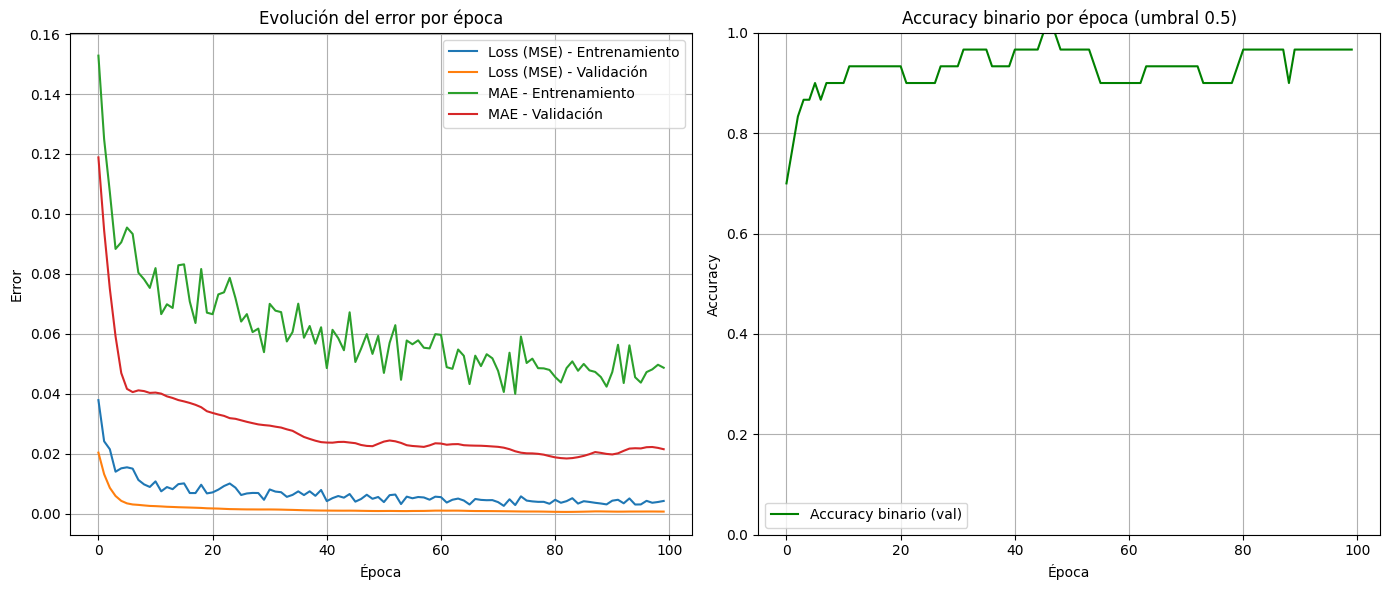

In [3]:
# =======================
# 12. GRAFICAR LOSS, MAE Y ACCURACY
# =======================

# Extraer valores de loss y MAE por época
loss_values = history.history['loss']
val_loss_values = history.history['val_loss']
mae_values = history.history['mean_absolute_error']
val_mae_values = history.history['val_mean_absolute_error']
accuracy_values = accuracy_callback.val_accuracies

# Crear figura con 2 subplots
plt.figure(figsize=(14, 6))

# Subplot 1: Loss y MAE
plt.subplot(1, 2, 1)
plt.plot(loss_values, label='Loss (MSE) - Entrenamiento')
plt.plot(val_loss_values, label='Loss (MSE) - Validación')
plt.plot(mae_values, label='MAE - Entrenamiento')
plt.plot(val_mae_values, label='MAE - Validación')
plt.title("Evolución del error por época")
plt.xlabel("Época")
plt.ylabel("Error")
plt.legend()
plt.grid(True)

# Subplot 2: Accuracy
plt.subplot(1, 2, 2)
plt.plot(accuracy_values, label='Accuracy binario (val)', color='green')
plt.title("Accuracy binario por época (umbral 0.5)")
plt.xlabel("Época")
plt.ylabel("Accuracy")
plt.ylim(0, 1)
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

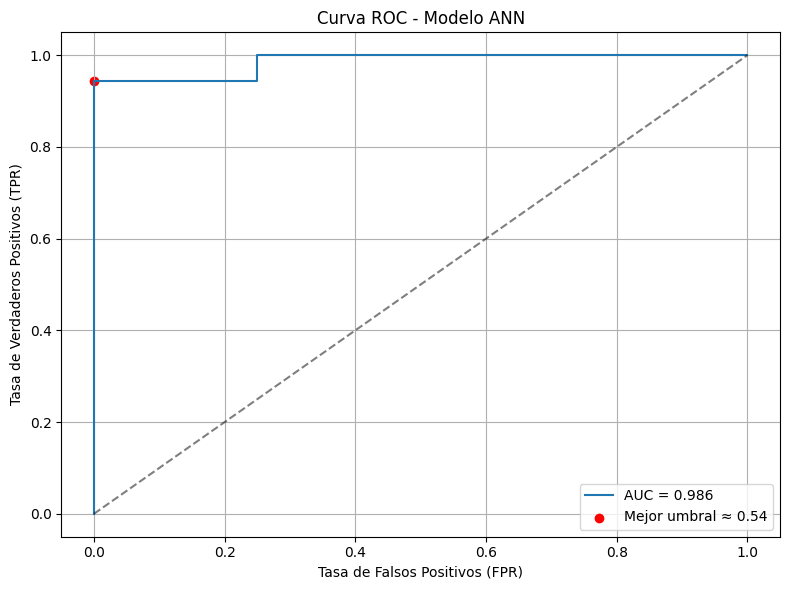


🔍 Mejor umbral de decisión según ROC: 0.539


In [4]:
from sklearn.metrics import roc_curve, roc_auc_score

# 1. Crear etiquetas verdaderas binarias y predicciones
y_true_bin = (y_test.values > 0.5).astype(int)
y_scores = y_pred.flatten()  # probabilidades predichas

# 2. Calcular curva ROC
fpr, tpr, thresholds = roc_curve(y_true_bin, y_scores)
auc = roc_auc_score(y_true_bin, y_scores)

# 3. Encontrar mejor umbral (distancia mínima a (0,1))
distancias = np.sqrt((fpr)**2 + (1 - tpr)**2)
mejor_idx = np.argmin(distancias)
mejor_umbral = thresholds[mejor_idx]

# 4. Graficar curva ROC
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f'AUC = {auc:.3f}')
plt.scatter(fpr[mejor_idx], tpr[mejor_idx], color='red', label=f"Mejor umbral ≈ {mejor_umbral:.2f}")
plt.plot([0, 1], [0, 1], 'k--', alpha=0.5)
plt.title("Curva ROC - Modelo ANN")
plt.xlabel("Tasa de Falsos Positivos (FPR)")
plt.ylabel("Tasa de Verdaderos Positivos (TPR)")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

# 5. Imprimir mejor umbral
print(f"\n🔍 Mejor umbral de decisión según ROC: {mejor_umbral:.3f}")

In [5]:
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score

# 1. Usar el mejor umbral para clasificar
y_pred_bin = (y_pred.flatten() > mejor_umbral).astype(int)
y_true_bin = (y_test.values > 0.5).astype(int)

# 2. Calcular métricas
acc = accuracy_score(y_true_bin, y_pred_bin)
prec = precision_score(y_true_bin, y_pred_bin)
rec = recall_score(y_true_bin, y_pred_bin)
f1 = f1_score(y_true_bin, y_pred_bin)
cm = confusion_matrix(y_true_bin, y_pred_bin)

# 3. Mostrar resultados
print("=== Evaluación con mejor umbral encontrado (≈ {:.2f}) ===".format(mejor_umbral))
print(f"Accuracy:  {acc:.4f}")
print(f"Precisión: {prec:.4f}")
print(f"Recall:    {rec:.4f}")
print(f"F1-Score:  {f1:.4f}")
print("\nMatriz de Confusión:")
print(cm)

=== Evaluación con mejor umbral encontrado (≈ 0.54) ===
Accuracy:  0.9333
Precisión: 1.0000
Recall:    0.8889
F1-Score:  0.9412

Matriz de Confusión:
[[12  0]
 [ 2 16]]


In [6]:
# =======================
# 1. DEFINIR NUEVOS CASOS
# =======================
nuevos_datos = pd.DataFrame([
    {
        'RMR': 45, 'Q': 1.2, 'RQD%': 57, 'UCS': 10,
        'Techo abovedado_bin': 1, 'Presencia de gradas en el techo_bin': 0,
        'Fallas/Fracturas desfavorables_bin': 1, 'Presencia de agua_bin': 0,
        'Litología': 'CAPAS ROJAS'
    },
    {
        'RMR': 75, 'Q': 5.0, 'RQD%': 92, 'UCS': 8,
        'Techo abovedado_bin': 0, 'Presencia de gradas en el techo_bin': 0,
        'Fallas/Fracturas desfavorables_bin': 0, 'Presencia de agua_bin': 0,
        'Litología': 'ANDESITAS'
    },
    {
        'RMR': 58, 'Q': 4.5, 'RQD%': 70, 'UCS': 7,
        'Techo abovedado_bin': 0, 'Presencia de gradas en el techo_bin': 1,
        'Fallas/Fracturas desfavorables_bin': 1, 'Presencia de agua_bin': 1,
        'Litología': 'ARENISCAS'
    },
    {
        'RMR': 38, 'Q': 0.9, 'RQD%': 45, 'UCS': 4,
        'Techo abovedado_bin': 1, 'Presencia de gradas en el techo_bin': 1,
        'Fallas/Fracturas desfavorables_bin': 1, 'Presencia de agua_bin': 1,
        'Litología': 'CAPAS ROJAS'
    }
])

nuevos_datos["Total_calc"] = nuevos_datos[[
    'Techo abovedado_bin', 'Presencia de gradas en el techo_bin',
    'Fallas/Fracturas desfavorables_bin', 'Presencia de agua_bin'
]].sum(axis=1)

# =======================
# 2. UNIR CON LA BASE GENERAL
# =======================
df_total = pd.concat([df.copy(), nuevos_datos.copy()], ignore_index=True)

# =======================
# 3. NORMALIZAR RIESGOS (MIN-MAX INVERSO)
# =======================
# Evitar errores por nulos
df_total = df_total.dropna(subset=["RMR", "Q", "RQD%"])

rmr_max = df_total["RMR"].max()
rmr_min = df_total["RMR"].min()
df_total["RMR_risk"] = 1 - (df_total["RMR"] - rmr_min) / (rmr_max - rmr_min)

q_max = df_total["Q"].max()
q_min = df_total["Q"].min()
df_total["Q_risk"] = 1 - (df_total["Q"] - q_min) / (q_max - q_min)

rqd_max = df_total["RQD%"].max()
rqd_min = df_total["RQD%"].min()
df_total["RQD_risk"] = 1 - (df_total["RQD%"] - rqd_min) / (rqd_max - rqd_min)

# =======================
# 4. PROBABILIDAD TOTAL TEÓRICA
# =======================
df_total["probabilidad de caida de rocas"] = (
    (df_total["Total_calc"] / 4) * 0.4 +
    df_total["RMR_risk"] * 0.2 +
    df_total["Q_risk"] * 0.2 +
    df_total["RQD_risk"] * 0.2
).clip(0, 1)

# =======================
# 5. TRANSFORMAR Y PREDECIR CON ANN
# =======================
# Asegura que 'features_numericas' y 'features_categoricas' estén definidos correctamente antes
X_full = df_total[features_numericas + features_categoricas]
X_full_processed = preprocessor.transform(X_full)
y_full_pred = model.predict(X_full_processed)

df_total["probabilidad estimada por ANN"] = y_full_pred.flatten()

# =======================
# 6. MOSTRAR SOLO NUEVOS CASOS
# =======================
print(df_total.tail(4)[[
    'RMR', 'Q', 'RQD%', 'Litología',
    'Total_calc', 'RMR_risk', 'Q_risk', 'RQD_risk',
    'probabilidad de caida de rocas',
    'probabilidad estimada por ANN'
]])

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 
     RMR    Q  RQD%    Litología  Total_calc  RMR_risk    Q_risk  RQD_risk  \
98    45  1.2  57.0  CAPAS ROJAS           2  0.638298  0.886071  0.536304   
99    75  5.0  92.0    ANDESITAS           0  0.000000  0.521947  0.000000   
100   58  4.5  70.0    ARENISCAS           3  0.361702  0.569858  0.337105   
101   38  0.9  45.0  CAPAS ROJAS           4  0.787234  0.914817  0.720179   

     probabilidad de caida de rocas  probabilidad estimada por ANN  
98                         0.612134                       0.511487  
99                         0.104389                       0.138863  
100                        0.553733                       0.439323  
101                        0.884446                       0.807604  


In [7]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np

# =======================
# 7. MÉTRICAS DE VALIDACIÓN
# =======================

# Variables reales vs. predichas
y_true = df_total["probabilidad de caida de rocas"]
y_pred = df_total["probabilidad estimada por ANN"]

# Cálculos
mae = mean_absolute_error(y_true, y_pred)
mse = mean_squared_error(y_true, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_true, y_pred)

# Mostrar resultados
print(f"MAE (Error Absoluto Medio): {mae:.4f}")
print(f"MSE (Error Cuadrático Medio): {mse:.4f}")
print(f"RMSE (Raíz del Error Cuadrático Medio): {rmse:.4f}")
print(f"R² (Coeficiente de determinación): {r2:.4f}")

MAE (Error Absoluto Medio): 0.0770
MSE (Error Cuadrático Medio): 0.0068
RMSE (Raíz del Error Cuadrático Medio): 0.0824
R² (Coeficiente de determinación): 0.7013


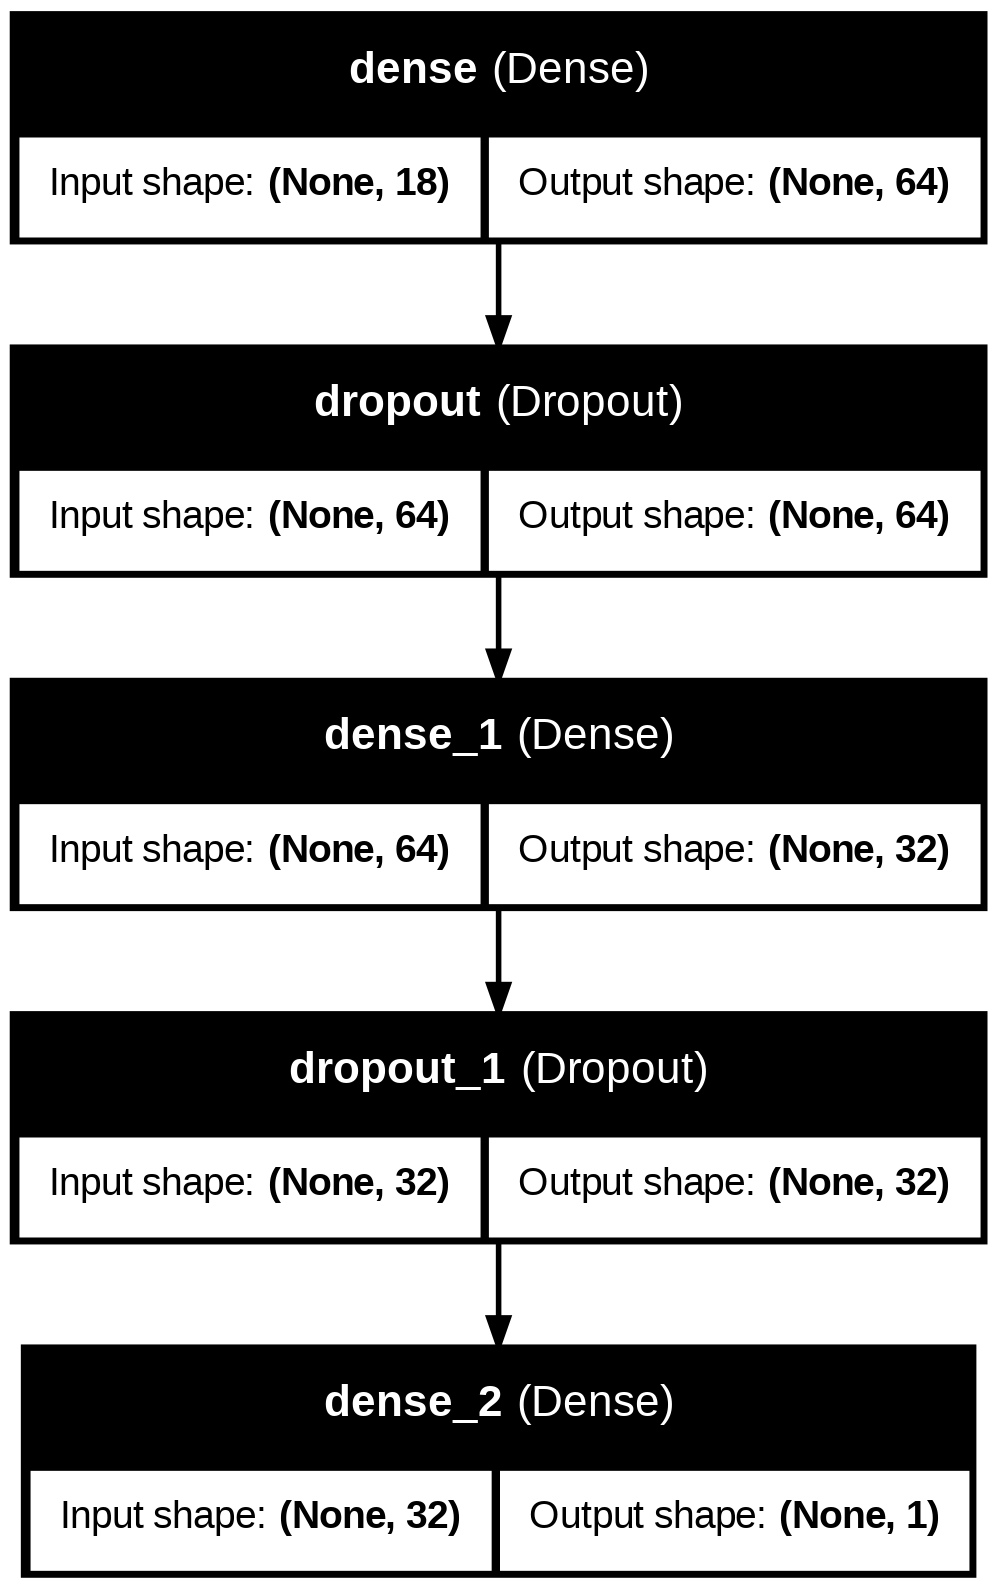

In [8]:
from tensorflow.keras.utils import plot_model
plot_model(model, to_file='model.png', show_shapes=True, show_layer_names=True)